In [156]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

In [155]:
#przedział funkcji
a = -4*math.pi
b = 3*math.pi
#liczba punktów na wykresach i przy obliczaniu błędów
points = 1000

In [77]:
def data_plot(xs, ys, label=''):
    plt.xlabel('x')
    plt.ylabel('y')
    plt.plot(xs, ys)
    if label: plt.legend(loc="best")


def func_plot(fn, a, b, n, label='', color='', figsize=(6, 4), subplot=None, title=''):
    if subplot is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        ax = subplot
    xs = np.linspace(a, b, num=n)
    ys = [fn(xi) for xi in xs]
    if color:
        ax.plot(xs, ys, label=label, color=color)
    else:
        ax.plot(xs, ys, label=label)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    if label:
        ax.legend(loc="best")
    if title:
        ax.set_title(title)


In [115]:
def create_compare_errors_table(data):
    df = pd.DataFrame(data, index=["Błąd bezwzględny", "Błąd średniokwadratowy"])
    return df


In [79]:
def max_absolute_error(f, W, xs):
    return max([abs(f(x) - W(x)) for x in xs])


In [80]:
def mse(f, W, xs):
    return sum([(f(x) - W(x)) ** 2 for x in xs]) / len(xs)

In [131]:
def display_interpolation(f, a,b,n, interpolations, labels,colors=[], boundary_conditions = [[True, True],[True,
                                                                                                           True,]],
                          title=""):
    xs = np.linspace(a,b, points)
    fig, ax = plt.subplots(figsize=(6, 4))
    polynomials = []
    for i in range(len(interpolations)):
        if boundary_conditions[i][0]:
             polynomials.append(interpolations[i](f,a,b,n, natural=boundary_conditions[i][0], ax=ax))
        if boundary_conditions[i][1]:
            polynomials.append(interpolations[i](f,a,b,n, natural=not boundary_conditions[i][0], ax=ax))




    # for interpolation in interpolations:
    #     if all:
    #         polynomials.append(interpolation(f,a,b,n, natural=True, ax=ax))
    #         polynomials.append(interpolation(f,a,b,n, natural=False, ax=ax))
    #     else:
    #         polynomials.append(interpolation(f,a,b,n, natural=natural, ax=ax))
    poly_n = len(polynomials)
    poly_errors = {}
    func_plot(f, a, b, 1000, label="f(x)", subplot=ax)
    while len(colors) < poly_n:
        colors.append('')
    for i in range(poly_n):
        func_plot(polynomials[i], a, b, 1000, label=labels[i], subplot=ax, color=colors[i], title=title)
        poly_errors[labels[i]] = [max_absolute_error(f, polynomials[i] ,xs), mse(f,polynomials[i] ,xs)]

    plt.show()
    display(create_compare_errors_table(poly_errors))


In [111]:
class QuadraticSpline:
    def __init__(self, xs, ys):
        self.n = len(xs)
        self.xs = xs
        self.ys = ys
        self.functions = []
    def s(self, i,a,b,c):
        return lambda x: a[i]*(x-self.xs[i]) ** 2 + b[i]*(x-self.xs[i]) + c[i]
    def natural_spline(self):
        a = []
        b = [0]
        c = self.ys
        self.find_factors(a,b)
        self.find_functions(a,b,c)
        return self.interpolation_val
    def clamped_boundary(self):
        a = []
        b_0 = (self.ys[1]-self.ys[0])/(self.xs[1]-self.xs[0])
        b = [b_0]
        c = self.ys
        self.find_factors(a,b)
        self.find_functions(a,b,c)
        return self.interpolation_val
    def find_factors(self,a,b):
        for i in range(1, self.n):
            b.append(2*(self.ys[i]-self.ys[i-1])/(self.xs[i]-self.xs[i-1])-b[-1])
        for i in range(self.n - 1):
            a.append((b[i + 1] - b[i]) / (2 * (self.xs[i + 1] - self.xs[i])))

    def find_functions(self, a,b,c):
        for i in range(self.n-1):
            self.functions.append(self.s(i,a,b,c))

    def interpolation_val(self,x):
        index = 0
        if x < self.xs[0] or x>self.xs[-1]:
            return 0
        for i in range(self.n-1):
            if self.xs[i]<=x and self.xs[i+1]>=x:
                index = i
                break
        return self.functions[index](x)


In [83]:

def quadtratic_spline_func(f, a, b, n, natural=True,ax=None):
    x = np.linspace(a, b, n)
    y = [f(xi) for xi in x]
    if ax is not None:
        ax.plot(x, y, 'o', c="r")
    if natural:
        return QuadraticSpline(x, y).natural_spline()
    return QuadraticSpline(x, y).clamped_boundary()

In [84]:
class CubicSpline:
    def __init__(self, xs, ys):
        self.n = len(xs)
        self.xs = xs
        self.ys = ys
        self.functions = []
        self.h = [xs[i + 1] - xs[i] for i in range(self.n - 1)]

    def s(self, i, b, c, d):
        return lambda x: self.ys[i] + b[i] * (x - self.xs[i]) + c[i] * (x - self.xs[i]) ** 2 + d[i] * (
                    x - self.xs[i]) ** 3

    def calculate_deltas_of_degree(self, degree):
        deltas = [list(self.ys)]
        for j in range(1, degree + 1):
            deltas.append([(deltas[j - 1][i + 1] - deltas[j - 1][i]) / (self.xs[i + j] - self.xs[i]) for i in range(self
                                                                                                                .n -
                                                                                                            j)])
        return deltas[degree]

    def cubic_spline_interpolation(self, natural=True):
        deltas_1 = self.calculate_deltas_of_degree(1)
        Y_vec = np.array([deltas_1[i + 1] - deltas_1[i] for i in range(len(deltas_1) - 1)])
        A_matrix = np.array([([0 for _ in range(j)] + [self.h[j], 2 * (self.h[j] + self.h[j + 1]), self.h[j + 1]] + [
            0 for _ in range(len(self.h) - 2 - j)]) for j in range(len(self.h) - 1)])
        if natural:
            Y_vec, A_matrix = self.natural_spline(Y_vec, A_matrix)
        else:
            Y_vec, A_matrix = self.cube_spline(Y_vec, A_matrix)
        Y_vec = np.array(Y_vec, dtype=np.float64)
        A_matrix = np.array(A_matrix, dtype=np.float64)
        sigma = np.linalg.solve(A_matrix, Y_vec)

        b, c, d = self.find_factors(sigma)

        self.find_functions(b, c, d)
        return self.interpolation_val

    def natural_spline(self, Y_vec, A_matrix):
        Y_vec = np.concatenate(([0], Y_vec, [0]))
        A_matrix = np.concatenate(([[1] + [0 for _ in range(self.n-1)]],
                                   A_matrix, [[0 for _ in range(self.n-1)] + [1]]), axis=0)

        return Y_vec, A_matrix

    def cube_spline(self, Y_vec, A_matrix):
        A_matrix = np.concatenate(([[-self.h[0], self.h[0]] + [0 for _ in range(self.n - 2)]],
                                   A_matrix, [[0 for _ in range(self.n - 2)] + [self.h[self.n - 2], -self.h[self
                                   .n-2]]]),
                                  axis=0)
        deltas = self.calculate_deltas_of_degree(3)
        y_0 = self.h[0] ** 2 * deltas[0]
        y_n_1= -self.h[self.n - 2] ** 2 * deltas[-1]
        Y_vec = np.concatenate(([y_0], Y_vec, [y_n_1]))

        return Y_vec, A_matrix



    def find_factors(self, sigma):
        b = [(self.ys[i + 1] - self.ys[i]) / self.h[i] - self.h[i] * (sigma[i + 1] + 2 * sigma[i]) for i in range(self
                                                                                                                  .n - 1)]
        c = [3 * sigma[i] for i in range(self.n - 1)]
        d = [(sigma[i + 1] - sigma[i]) / self.h[i] for i in range(self.n - 1)]
        return b, c, d

    def find_functions(self, b, c, d):
        for i in range(self.n - 1):
            self.functions.append(self.s(i, b, c, d))

    def interpolation_val(self, x):
        index = 0
        if x < self.xs[0] or x > self.xs[-1]:
            return 0
        for i in range(self.n - 1):
            if self.xs[i] <= x and self.xs[i + 1] >= x:
                index = i
                break
        return self.functions[index](x)


In [85]:
def cubic_spline_func(f, a, b, n, natural=True, ax=None):
    x = np.linspace(a, b, n)
    y = [f(xi) for xi in x]
    if ax is not None:
        ax.plot(x, y, 'o', c="r")
    return CubicSpline(x, y).cubic_spline_interpolation(natural=natural)

In [157]:
f = lambda x, k=4, m=1: math.exp(-k * math.sin(m * x)) + k * math.sin(m * x) - 1

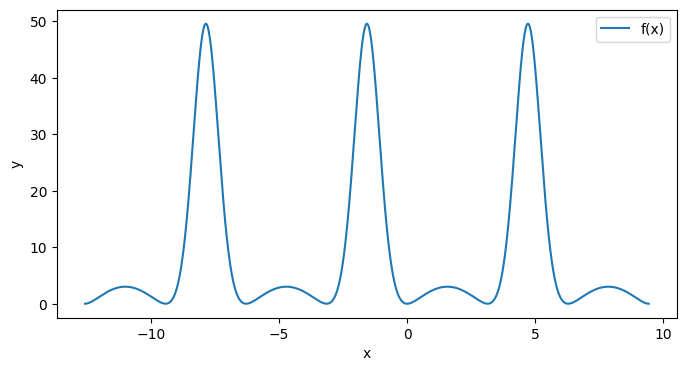

In [158]:
func_plot(f, a, b, 1000, label="f(x)", figsize=(8,4))

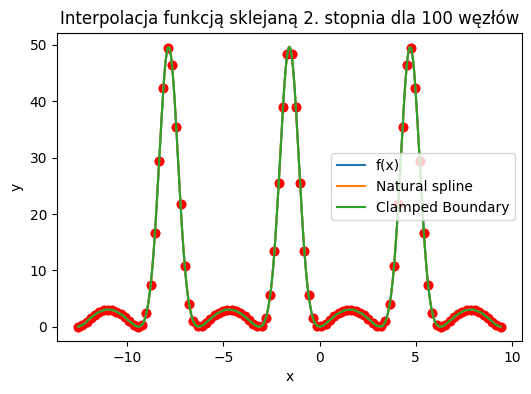

,Natural spline,Clamped Boundary
Błąd bezwzględny,0.076971,0.119464
Błąd średniokwadratowy,0.000426,0.002226


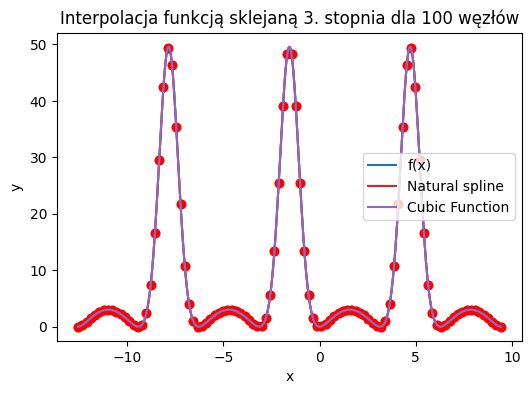

,Natural spline,Cubic Function
Błąd bezwzględny,0.036011,0.023453
Błąd średniokwadratowy,0.000032,0.000019


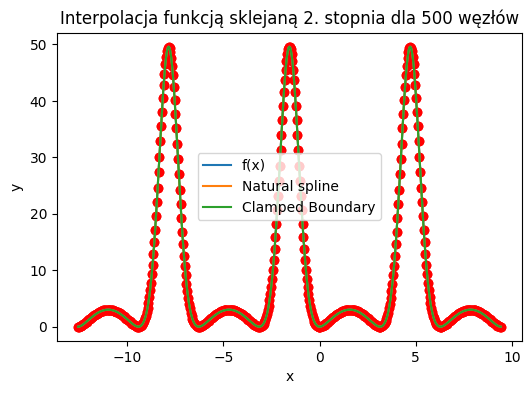

,Natural spline,Clamped Boundary
Błąd bezwzględny,4.984132e-04,0.003628
Błąd średniokwadratowy,1.926599e-08,0.000007


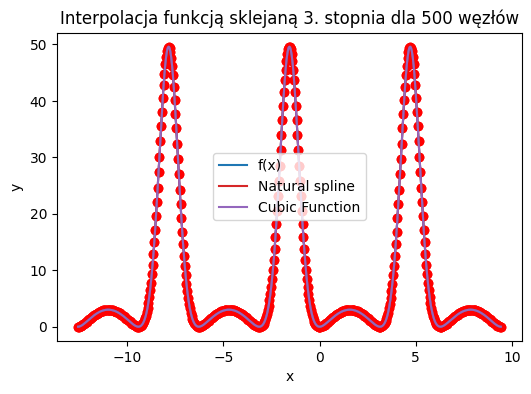

,Natural spline,Cubic Function
Błąd bezwzględny,1.418045e-03,2.561807e-05
Błąd średniokwadratowy,4.360528e-09,2.521752e-11


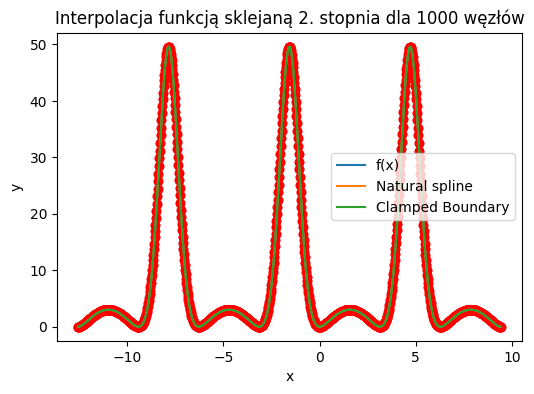

,Natural spline,Clamped Boundary
Błąd bezwzględny,3.469447e-18,3.469447e-18
Błąd średniokwadratowy,3.291384e-38,5.510718e-38


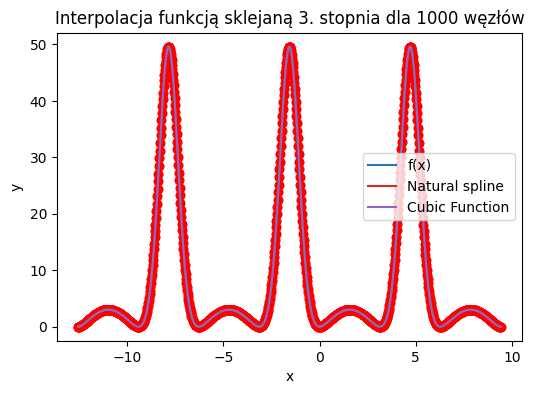

,Natural spline,Cubic Function
Błąd bezwzględny,7.105427e-15,7.105427e-15
Błąd średniokwadratowy,1.453970e-30,1.454048e-30


In [178]:
to_check = [100, 500, 1000]
for val in to_check:
    n=val
    display_interpolation(f,a,b,n, [quadtratic_spline_func], ["Natural spline", "Clamped Boundary"],
                      boundary_conditions=[[True,
                                                                                                              True]
                      ], title=f"Interpolacja funkcją sklejaną 2. stopnia dla {n} węzłów")
    display_interpolation(f,a,b,n, [cubic_spline_func], ["Natural spline", "Cubic Function"],
                      boundary_conditions=[[True,
                                                                                                              True]
                      ], title=f"Interpolacja funkcją sklejaną 3. stopnia dla {n} węzłów", colors=["#d62728", "#9467bd"])

# display_interpolation(f,a,b,3, [quadtratic_spline_func], ["Natural spline", "Clamped Boundary"],
#                       boundary_conditions=[[True,
#                                                                                                               True]
#                       ], title=f"Interpolacja funkcją sklejaną 2. stopnia dla {n} węzłów")
# display_interpolation(f,a,b,4, [cubic_spline_func], ["Natural spline", "Cubic Function"],
#                       boundary_conditions=[[True,
#                                                                                                               True]
#                       ], title=f"Interpolacja funkcją sklejaną 3. stopnia dla {n} węzłów", colors=["#d62728", "#9467bd"])

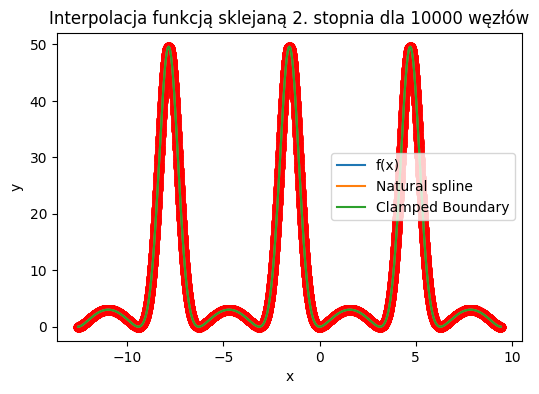

,Natural spline,Clamped Boundary
Błąd bezwzględny,4.452740e-08,9.631438e-06
Błąd średniokwadratowy,2.147842e-16,4.947520e-11


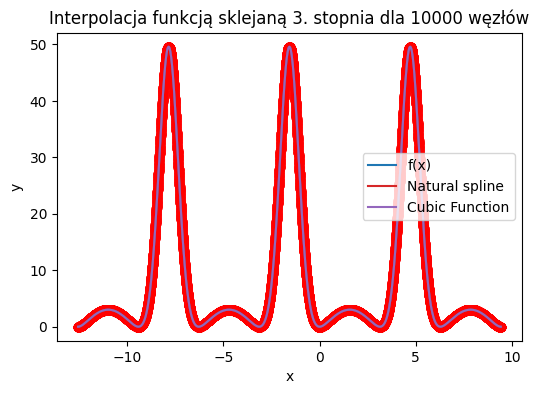

,Natural spline,Cubic Function
Błąd bezwzględny,1.724771e-10,1.724771e-10
Błąd średniokwadratowy,8.146183e-22,8.146181e-22


In [186]:
to_check = [10000]
for val in to_check:
    n=val
    display_interpolation(f,a,b,n, [quadtratic_spline_func], ["Natural spline", "Clamped Boundary"],
                      boundary_conditions=[[True,
                                                                                                              True]
                      ], title=f"Interpolacja funkcją sklejaną 2. stopnia dla {n} węzłów")
    display_interpolation(f,a,b,n, [cubic_spline_func], ["Natural spline", "Cubic Function"],
                      boundary_conditions=[[True,
                                                                                                              True]
                      ], title=f"Interpolacja funkcją sklejaną 3. stopnia dla {n} węzłów", colors=["#d62728", "#9467bd"])
